In [1]:
import graphix 
import numpy as np
from graphix import Circuit
import networkx as nx
import matplotlib.pyplot as plt
from graphix.gflow import flow 
from graphix.pattern import *



import sympy as sp 


### New Parameter Class 

In [2]:
from graphix.parameter import Parameter

##### Example

In [3]:
th = Parameter('th');
th

expr = th 

In [4]:
np.sin(th/3)

expr = sin(th/3) 

In [5]:
th.bind({th:0.3})

expr = sin(th/3), assignment = [ th : 0.3 ]

In [6]:
th.value 

0.09983341664682814

##### Issues

In [7]:
mu = Parameter('mu')
gu = Parameter('gu')


In [8]:
## uncomment the line below to check issues regarding interaction of multiple instances of Parameter class

# gu + mu

### Compatibility Illustration

In [9]:
## helper 


def process_layer_data(graph: nx.Graph, layer_map: dict):

    node_attributes = {}; max_l = max(set(layer_map.values()))
    layer_data = {n: set() for n in range(max_l +1 )}

    for v in graph.nodes():
        # print(v); print(layer_data[v])
        node_attributes[v] = {"layer" : layer_map[v]}
        layer_data[layer_map[v]].add(v)

    return {'attribute_data' : node_attributes, 'nodes_in_layers': layer_data, 'num_layers' : max_l  }


def get_nx_graph(pattern: graphix.Pattern):
    nodes, edges = pattern.get_graph()
    g = nx.Graph()
    g.add_nodes_from(nodes)
    g.add_edges_from(edges)

    return g

def get_pos(pattern: graphix.Pattern, f:dict):

    num_output_nodes = len(pattern.output_nodes)
    flow = [[i] for i in range(num_output_nodes)]
    for i in range(num_output_nodes):
        contd = True
        val = i
        while contd:
            try:
                val = f[val]
                flow[i].append(val)
            except KeyError:
                contd = False
    longest = np.max([len(flow[i]) for i in range(num_output_nodes)])

    pos = dict()
    for i in range(num_output_nodes):
        length = len(flow[i])
        fac = longest / (length - 1)
        for j in range(len(flow[i])):
            pos[flow[i][j]] = (fac * j, -i)
    
    return pos, longest

# determine wheher or not a node will be measured in Pauli basis
def get_clr_list(pattern):
    nodes, edges = pattern.get_graph()
    meas_list = pattern.get_measurement_commands()
    g = get_nx_graph(pattern)
    clr_list = []
    for i in g.nodes:
        for cmd in meas_list:
            if cmd[1] == i:
                if cmd[3] in [-1, -0.5, 0, 0.5, 1]:
                    clr_list.append([0.5, 0.5, 0.5])
                else:
                    clr_list.append([1, 1, 1])
        if i in pattern.output_nodes:
            clr_list.append([0.8, 0.8, 0.8])
    return clr_list

def pretty_plot_pattern(pattern: graphix.Pattern, input_nodes : set):

    clr_list = get_clr_list(pattern)
    g = get_nx_graph(pattern)
    f, l_k = flow(g, input_nodes, set(pattern.output_nodes))
    
    assert isinstance(f, dict)
    pos, length = get_pos(pattern, f) ; layer_data = process_layer_data(g, l_k)
    
    nx.set_node_attributes(g, layer_data['attribute_data'])

    graph_params = {"with_labels": True, "node_size": 600, "node_color": 'w', "edgecolors": "k"}
    pos = nx.multipartite_layout(g, subset_key= 'layer', align='vertical', scale= 100)

    plt.figure(figsize=(25,16))

    for layer in range(layer_data['num_layers']):   
        vertx_1 = next(iter(layer_data['nodes_in_layers'][layer])); xcoord_1 = pos[vertx_1][0]
        vertx_2 = next(iter(layer_data['nodes_in_layers'][layer + 1])); xcoord_2 = pos[vertx_2][0]
        xcoord = np.mean([xcoord_1, xcoord_2])
        plt.axvline(xcoord)
        plt.text(x= xcoord + 1.5, y= -18, s= 'l= ' + str(layer) )

    edge_color= []
    for u,v in g.edges():
        if( u not in pattern.output_nodes and v not in pattern.output_nodes ) :
            # print (u,v, u==f[v] or v== f[u])
            if u==f[v] or v== f[u] :
                edge_color.append('r')
            else :
                edge_color.append('g')


    nx.draw_networkx(g, pos= pos, **graph_params, edge_color = edge_color)

    
    

            

#### Variational Ansatz

In [10]:
def build_basic_ansatz(n: int, layers: int, params: list ):

    assert len(params) == n * layers ## checks

    c = Circuit(n)
    for l in range(layers):
        
        for i in range(n): ## circular entangelemnt 
            c.cnot(i %n,(i+1)%n)

        for i in range(n): ## paramterised rx rotations 
            c.rx(i, params[ n*l + i]) 

    return c

In [11]:
## generate random circuit 
n = 2
# params = ParameterVector(name= 'p', length= n * 1)
params = [ Parameter('th1'), Parameter('th2')]
crc2 = build_basic_ansatz(n, 1, params= params )

In [12]:
## check circuit params
crc2.instruction

[['CNOT', [0, 1]],
 ['CNOT', [1, 0]],
 ['Rx', 0, expr = 1.0*th1 ],
 ['Rx', 1, expr = 1.0*th2 ]]

In [13]:
## inspect attribriutes
crc2.is_parameterized, crc2.num_parameterized_gates, crc2.parameters

(True, 2, {th1, th2})

In [14]:
## dictionary of asssignments 
param_assignments = { params[i]: np.random.random() for i in range(len(params))}

In [15]:
crc2_copy = deepcopy(crc2)

In [16]:
## assign parameters to circuit
crc2.assign_parameters(parameter_assignment= param_assignments, inplace=True, verbose= True )

['Rx', 0, 0.4307656354946672]
['Rx', 1, 0.8754031042476935]
all parameter values assigned


In [17]:
crc2.instruction

[['CNOT', [0, 1]],
 ['CNOT', [1, 0]],
 ['Rx', 0, 0.4307656354946672],
 ['Rx', 1, 0.8754031042476935]]

In [18]:
## statevector simulation 
st = crc2.simulate_statevector()
st.psi

array([[0.3971067-0.30381947j, 0.3971067-0.30381947j],
       [0.3971067-0.30381947j, 0.3971067-0.30381947j]])

In [19]:
## generate pattern
ptrn2 = crc2_copy.standardize_and_transpile(opt=True)
ptrn2.get_measurement_commands()

[['M', 1, 'XY', 0, [], []],
 ['M', 2, 'XY', 0, [], []],
 ['M', 0, 'XY', 0, [], []],
 ['M', 4, 'XY', 0, [], []],
 ['M', 5, 'XY', 0, [], []],
 ['M', 6, 'XY', expr = -0.318309886183791*th1 , [5, 0, 1], []],
 ['M', 3, 'XY', 0, [], []],
 ['M', 8, 'XY', expr = -0.318309886183791*th2 , [3, 0, 1, 1], []]]

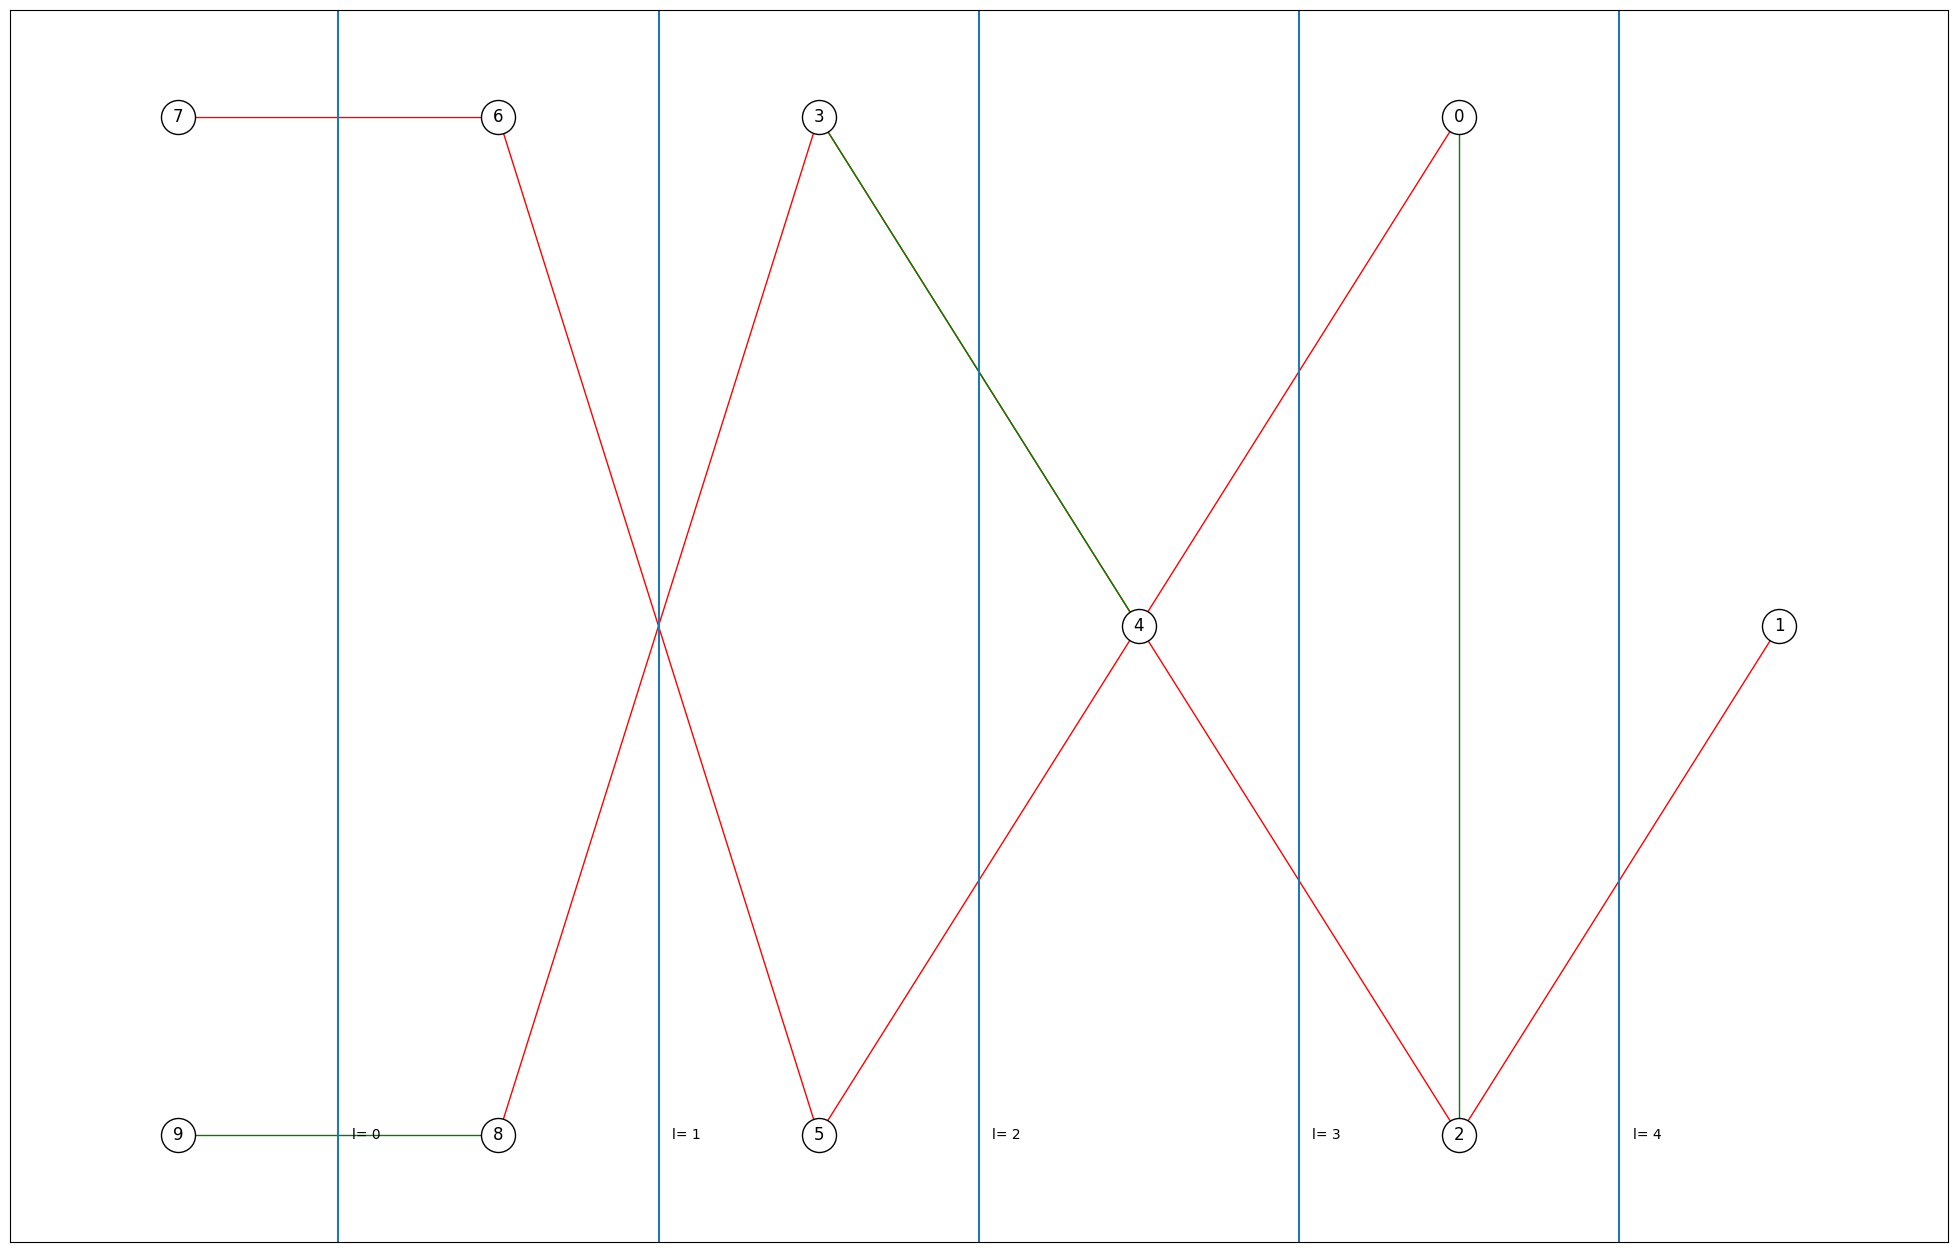

In [20]:
pretty_plot_pattern(ptrn2, {0,1})

In [21]:
## check pauli nodes
a, b = pauli_nodes(ptrn2)

In [22]:
a

[['M', 1, 'XY', 0, [], []],
 ['M', 2, 'XY', 0, [], []],
 ['M', 0, 'XY', 0, [], []],
 ['M', 4, 'XY', 0, [], []],
 ['M', 5, 'XY', 0, [], []],
 ['M', 3, 'XY', 0, [], []]]

In [23]:
b

[['M', 6, 'XY', expr = -0.318309886183791*th1 , [5, 0, 1], []],
 ['M', 8, 'XY', expr = -0.318309886183791*th2 , [3, 0, 1, 1], []]]

In [24]:
## check attribrutes
ptrn2.is_parameterized, ptrn2.parameters, ptrn2.parameterized_commands

(True,
 {th1, th2},
 [{6: expr = -0.318309886183791*th1 }, {8: expr = -0.318309886183791*th2 }])

In [25]:
## assign parameters 
ptrn2.assign_parameters(parameter_assignment= param_assignments, inplace= True)

all parameter values assigned


In [26]:
ptrn2.parameterized_commands, ptrn2.parameters

([], set())

In [27]:
# assign_params_in_pattern(ptrn2, param_assignments)
ptrn2.get_measurement_commands()

[['M', 1, 'XY', 0, [], []],
 ['M', 2, 'XY', 0, [], []],
 ['M', 0, 'XY', 0, [], []],
 ['M', 4, 'XY', 0, [], []],
 ['M', 5, 'XY', 0, [], []],
 ['M', 6, 'XY', -0.13711696040619578, [5, 0, 1], []],
 ['M', 3, 'XY', 0, [], []],
 ['M', 8, 'XY', -0.27864946247802036, [3, 0, 1, 1], []]]

In [28]:
ptrn2.simulate_pattern()

Statevec, data=[[[[0.25+0.j 0.25+0.j]
   [0.25+0.j 0.25+0.j]]

  [[0.25+0.j 0.25+0.j]
   [0.25+0.j 0.25+0.j]]]


 [[[0.25+0.j 0.25+0.j]
   [0.25+0.j 0.25+0.j]]

  [[0.25+0.j 0.25+0.j]
   [0.25+0.j 0.25+0.j]]]], shape=(2, 2, 2, 2)